# Import Libraries

In [3]:
import numpy as np
import pandas as pd
pd.set_option("max_columns", None)
from scipy.stats import chi2_contingency
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold

from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation, Dropout
from keras.optimizers import Adadelta
from keras.layers.advanced_activations import LeakyReLU
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense

import matplotlib
import matplotlib.pyplot as plt

Using TensorFlow backend.
/Users/wentingxie/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/wentingxie/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/wentingxie/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/wentingxie/venv/lib/python3.7/site-packages/tenso

# Import Data

In [4]:
data = pd.read_csv('fashion_data_on_Instagram.csv')
data.set_index('UserId', inplace = True)
data.head()

,Followings,Followers,MediaCount,BrandName,BrandCategory,Hashtags,Caption,ImgURL,Likes,Comments,CreationTime,Link,Selfie,BodySnap,Marketing,ProductOnly,NonFashion,Face,Logo,BrandLogo,Smile,Outdoor,NumberOfPeople,NumberOfFashionProduct,Anger,Contempt,Disgust,Fear,Happiness,Neutral,Sadness,Surprise
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1171579752855683619_212070047,518.0,9840.0,541,abercrombie,High street,"beautiful, summer, fashion, love, cute, food, ...","We were born to be REAL, not to be perfect. ...",https://scontent.cdninstagram.com/t51.2885-15/...,97,0,1453883211,https://www.instagram.com/p/BBCSZPzAMIj/,0.000885,0.336438,0.741220,0.009454,0.001827,0.839466,0.890231,0.292843,0.062638,0.012164,0.931486,3.42211,0.083862,0.015089,0.000583,0.000026,0.000017,0.890586,0.009657,0.000181
1171594777274371222_176762322,7333.0,2300.0,272,abercrombie,High street,"teen, model, brunette, selfie, hollister, snap...","Gotta run, but first, let me take selfie. Me...",https://scontent.cdninstagram.com/t51.2885-15/...,94,0,1453885002,https://www.instagram.com/p/BBCVz4YJEyW/,0.003912,0.995503,0.001728,0.002125,0.002438,0.480598,0.550629,0.063139,0.126848,0.004330,0.466329,2.91971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1171407552643586413_581125501,131.0,605.0,106,abercrombie,High street,"alexandani, cute, llbean, beanboots, anthropol...",dress to impress\U0001f457,https://scontent.cdninstagram.com/t51.2885-15/...,91,3,1453862683,https://www.instagram.com/p/BBBrPZ2h9lt/,0.015774,0.963880,0.025719,0.027023,0.003409,0.283399,0.095724,0.037635,0.107896,0.712017,1.116500,4.69096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1171407552643586413_581125501,131.0,605.0,106,abercrombie,High street,"alexandani, cute, llbean, beanboots, anthropol...",dress to impress\U0001f457,https://scontent.cdninstagram.com/t51.2885-15/...,94,3,1453862683,https://www.instagram.com/p/BBBrPZ2h9lt/,0.015774,0.963880,0.025719,0.027023,0.003409,0.283399,0.095724,0.037635,0.107896,0.712017,1.116500,4.69096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1171508187966229230_2797323089,132.0,456.0,56,abercrombie,High street,"abercrombieandfitch, shopping, love, hollister...",#love #shopping #shoppen #hollister #abercro...,https://scontent.cdninstagram.com/t51.2885-15/...,9,1,1453874680,https://www.instagram.com/p/BBCCH1zMEru/,0.002021,0.014188,0.028351,0.418125,0.601519,0.010840,0.994191,0.332847,0.007911,0.002386,0.393063,1.45586,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Clean Data

### Let's See if there are any NaNs in the data

In [3]:
hashtag = data.copy()
hashtag['Hashtags'] = data['Hashtags'].isna()
hashtag.groupby('Hashtags')['MediaCount'].count()

Hashtags
False    24606
True       146
Name: MediaCount, dtype: int64

In [4]:
Caption = data.copy()
Caption['Caption'] = data['Caption'].isna()
Caption.groupby('Caption')['MediaCount'].count()

Caption
False    24717
True        35
Name: MediaCount, dtype: int64

In [5]:
set(data['Comments '].isna())

{False}

##### So there exist NaN values in Hashtags and Captions. There are no other columns that contain NaN.

In [6]:
data.isna().groupby('Hashtags')['Followings'].count()

Hashtags
False    24606
True       146
Name: Followings, dtype: int64

##### There are 146 NaN rows in hashtags. It is possible that this is simply due to the fact that some posts do not have hashtags.

In [7]:
data.isna().groupby('Caption')['Followings'].count()

Caption
False    24717
True        35
Name: Followings, dtype: int64

##### There are 35 NaN rows in Caption

### Maybe the caption or hashtag information is missing because there is either only a caption or only hashtags....

In [8]:
hashtag_nan = list(data['Hashtags'].isna())
caption_nan = list(data['Caption'].isna())

In [9]:
count = 0
for i in range(len(hashtag_nan)):
    if hashtag_nan[i] and caption_nan[i]:
        count += 1
print('The number of times both hashtag_nan and caption_nan is true is', count)

The number of times both hashtag_nan and caption_nan is true is 18


##### So we have missing hashtag both 18/35 times that we have a missing caption. So it is not exactly correlated. Maybe we can just drop the rows that have missing caption or hashtag if we need to use these, or claim that there was not hashtag or caption for these rows.

In [10]:
chi2_contingency([[hashtag_nan.count(True), hashtag_nan.count(False)], [caption_nan.count(True), caption_nan.count(False)]])

(67.09615038449334, 2.585828482081104e-16, 1, array([[   90.5, 24661.5],
        [   90.5, 24661.5]]))

### I want to try and see if I can make brand category numeric

In [6]:
brand_category = pd.get_dummies(data['BrandCategory'])

In [12]:
brand_category.head()

,Designer,High street,Mega couture,Small couture
UserId,,,,
1171579752855683619_212070047,0,1,0,0
1171594777274371222_176762322,0,1,0,0
1171407552643586413_581125501,0,1,0,0
1171407552643586413_581125501,0,1,0,0
1171508187966229230_2797323089,0,1,0,0


In [7]:
data_new = pd.concat([data, brand_category], sort = False, axis = 1)
data_new.head()

,Followings,Followers,MediaCount,BrandName,BrandCategory,Hashtags,Caption,ImgURL,Likes,Comments,CreationTime,Link,Selfie,BodySnap,Marketing,ProductOnly,NonFashion,Face,Logo,BrandLogo,Smile,Outdoor,NumberOfPeople,NumberOfFashionProduct,Anger,Contempt,Disgust,Fear,Happiness,Neutral,Sadness,Surprise,Designer,High street,Mega couture,Small couture
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1171579752855683619_212070047,518.0,9840.0,541,abercrombie,High street,"beautiful, summer, fashion, love, cute, food, ...","We were born to be REAL, not to be perfect. ...",https://scontent.cdninstagram.com/t51.2885-15/...,97,0,1453883211,https://www.instagram.com/p/BBCSZPzAMIj/,0.000885,0.336438,0.741220,0.009454,0.001827,0.839466,0.890231,0.292843,0.062638,0.012164,0.931486,3.42211,0.083862,0.015089,0.000583,0.000026,0.000017,0.890586,0.009657,0.000181,0,1,0,0
1171594777274371222_176762322,7333.0,2300.0,272,abercrombie,High street,"teen, model, brunette, selfie, hollister, snap...","Gotta run, but first, let me take selfie. Me...",https://scontent.cdninstagram.com/t51.2885-15/...,94,0,1453885002,https://www.instagram.com/p/BBCVz4YJEyW/,0.003912,0.995503,0.001728,0.002125,0.002438,0.480598,0.550629,0.063139,0.126848,0.004330,0.466329,2.91971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0
1171407552643586413_581125501,131.0,605.0,106,abercrombie,High street,"alexandani, cute, llbean, beanboots, anthropol...",dress to impress\U0001f457,https://scontent.cdninstagram.com/t51.2885-15/...,91,3,1453862683,https://www.instagram.com/p/BBBrPZ2h9lt/,0.015774,0.963880,0.025719,0.027023,0.003409,0.283399,0.095724,0.037635,0.107896,0.712017,1.116500,4.69096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0
1171407552643586413_581125501,131.0,605.0,106,abercrombie,High street,"alexandani, cute, llbean, beanboots, anthropol...",dress to impress\U0001f457,https://scontent.cdninstagram.com/t51.2885-15/...,94,3,1453862683,https://www.instagram.com/p/BBBrPZ2h9lt/,0.015774,0.963880,0.025719,0.027023,0.003409,0.283399,0.095724,0.037635,0.107896,0.712017,1.116500,4.69096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0
1171508187966229230_2797323089,132.0,456.0,56,abercrombie,High street,"abercrombieandfitch, shopping, love, hollister...",#love #shopping #shoppen #hollister #abercro...,https://scontent.cdninstagram.com/t51.2885-15/...,9,1,1453874680,https://www.instagram.com/p/BBCCH1zMEru/,0.002021,0.014188,0.028351,0.418125,0.601519,0.010840,0.994191,0.332847,0.007911,0.002386,0.393063,1.45586,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0


##### Now the brand category is represented in the last four columns of the dataframe with one_hot_encoding.

# Model with Numeric Data Only

First, lets try to build a model with only the numeric data. This will be easy to do and will allow us to understand whether any of these numeric factors influence the number of likes/comments a user gets. 

## Likes Model

In [14]:
X = np.array(data_new[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor', 'NumberOfPeople',
       'NumberOfFashionProduct', 'Anger', 'Contempt', 'Disgust', 'Fear',
       'Happiness', 'Neutral', 'Sadness', 'Surprise', 'Designer',
       'High street', 'Mega couture', 'Small couture']])
y = np.array(data_new['Likes'])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [16]:
def standardize(train, test):


    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)+0.000001

    X_train = (train - mean) / std
    X_test = (test - mean) /std
    return X_train, X_test

In [17]:
X_train, X_test = standardize(X_train, X_test)

In [18]:
epsilon = 1e-200
y_train = np.log(y_train + epsilon)
y_test = np.log(y_test + epsilon)

Let's use a Lasso Regression model to regress based on the likes that we receive. I want to use lasso because lasso will send the unimportant variables to zero allowing us to see which features are important. 

In [19]:
lasso = Lasso(alpha = 0.1, max_iter = 10000).fit(X_train, y_train)

In [20]:
predictions = lasso.predict((X_test))
r2_score(y_test, predictions)

0.02953513081793302

Maybe ridge regression will work better?

In [21]:
ridge = Ridge(alpha = 0.1).fit(X_train, y_train)

In [22]:
predictions = ridge.predict((X_test))
r2_score(y_test, predictions)

0.028789646105978117

## Try with stratified crossvalidation

In [23]:
cv = StratifiedKFold(5)
lasso = Lasso(alpha = 0.1, max_iter = 10000)
for train, test in cv.split(X, y):
    X_train, X_test = standardize(X[train], X[test])
    epsilon = 1e-200
    y_train = np.log(y[train] + epsilon)
    y_test = np.log(y[test] + epsilon)
    
    lasso.fit(X_train, y_train)
    predictions = lasso.predict((X_test))
    print(r2_score(y_test, predictions))

/Users/sungwy92/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


0.03308285132362676
0.01662791735700586
0.023615001289229554
0.006028356774259169
0.03036761794880405


In [24]:
cv = StratifiedKFold(5)
ridge = Ridge(alpha = 0.1)
for train, test in cv.split(X, y):
    X_train, X_test = standardize(X[train], X[test])
    epsilon = 1e-200
    y_train = np.log(y[train] + epsilon)
    y_test = np.log(y[test] + epsilon)
    
    ridge.fit(X_train, y_train)
    predictions = lasso.predict((X_test))
    print(r2_score(y_test, predictions))

/Users/sungwy92/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


0.03353378010399599
0.02266811516995282
0.02667403430072035
0.01395320028874869
0.03036761794880405


# Remove Bias.

In [23]:
data_short = data_new[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor']]

In [24]:
selfie, body, marketing, product, nonfash, total = 0,0,0,0,0,0
selfiel, bodyl, marketingl, productl, nonfashl = [],[],[],[],[]
thresh = 0.75
for index, row in data_short.iterrows():
    if row['Selfie'] > thresh:
        selfie+=1
        selfiel.append(index)
    if row['BodySnap'] > thresh:
        body+=1
        bodyl.append(index)
    if row['Marketing'] > thresh:
        marketing+=1
        marketingl.append(index)
    if row['ProductOnly'] > thresh:
        product+=1
        productl.append(index)
    if row['NonFashion'] > thresh:
        nonfash+=1
        nonfashl.append(index)
    total+=1

print('Selfie: ', selfie/total * 100)
print('BodySnap: ', body/total * 100)
print('Marketing: ', marketing/total * 100)
print('ProductOnly: ', product/total * 100)
print('NonFashion: ', nonfash/total * 100)

Selfie:  1.3574660633484164
BodySnap:  22.551712992889463
Marketing:  5.2521008403361344
ProductOnly:  34.68810601163542
NonFashion:  7.558985132514544


### Try with the data that we increase the number of certain kinds of data

In [25]:
X = data_new[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor', 'NumberOfPeople',
       'NumberOfFashionProduct', 'Anger', 'Contempt', 'Disgust', 'Fear',
       'Happiness', 'Neutral', 'Sadness', 'Surprise', 'Designer',
       'High street', 'Mega couture', 'Small couture']]
y = data_new[['Likes']]

In [26]:
# add some random data to even out bias
import random
selfie_lst = selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel
indices = random.sample(selfie_lst, selfie*20)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])
marketing_lst = marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl
indices = random.sample(marketing_lst, marketing*5)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])
nonfash_lst = nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl
indices = random.sample(nonfash_lst, nonfash*2)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])

In [27]:
selfien, bodyn, marketingn, productn, nonfashn, totaln = 0,0,0,0,0,0
thresh = 0.75
for index, row in X.iterrows():
    if row['Selfie'] > thresh:
        selfien+=1
    if row['BodySnap'] > thresh:
        bodyn+=1
    if row['Marketing'] > thresh:
        marketingn+=1
    if row['ProductOnly'] > thresh:
        productn+=1
    if row['NonFashion'] > thresh:
        nonfashn+=1
    totaln+=1

print('Selfie: ', selfien/totaln * 100)
print('BodySnap: ', bodyn/totaln * 100)
print('Marketing: ', marketingn/totaln * 100)
print('ProductOnly: ', productn/totaln * 100)
print('NonFashion: ', nonfashn/totaln * 100)

Selfie:  16.78840800399724
BodySnap:  13.447857431773299
Marketing:  18.90837279021628
ProductOnly:  20.540579123938233
NonFashion:  13.857098669965975


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [29]:
def standardize(train, test):


    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)+0.000001

    X_train = (train - mean) / std
    X_test = (test - mean) /std
    return X_train, X_test

In [30]:
X_train, X_test = standardize(X_train, X_test)

In [31]:
epsilon = 1e-200
y_train = np.log(y_train + epsilon)
y_test = np.log(y_test + epsilon)

Let's use a Lasso Regression model to regress based on the likes that we receive. I want to use lasso because lasso will send the unimportant variables to zero allowing us to see which features are important. 

In [32]:
lasso = Lasso(alpha = 0.01, max_iter = 10000).fit(X_train, y_train)

In [33]:
predictions = lasso.predict((X_test))
r2_score(y_test, predictions)

0.023179036233414885

## Bad Model because it includes things we know likes are dependent on

In [34]:
X = data_new[['Followings', 'Followers', 'MediaCount','Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor', 'NumberOfPeople',
       'NumberOfFashionProduct', 'Anger', 'Contempt', 'Disgust', 'Fear',
       'Happiness', 'Neutral', 'Sadness', 'Surprise', 'Designer',
       'High street', 'Mega couture', 'Small couture']]
y = data_new['Likes']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [36]:
def standardize(train, test):


    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)+0.000001

    X_train = (train - mean) / std
    X_test = (test - mean) /std
    return X_train, X_test

In [37]:
X_train, X_test = standardize(X_train, X_test)

Let's use a Lasso Regression model to regress based on the likes that we receive. I want to use lasso because lasso will send the unimportant variables to zero allowing us to see which features are important. 

In [38]:
lasso = Lasso(alpha = 0.1, max_iter = 10000).fit(X_train, y_train)

In [39]:
predictions = lasso.predict((X_test))
r2_score(y_test, predictions)

0.2984377062815089

In [40]:
coeffs = lasso.coef_
coeffs

array([-6.58234530e+00,  8.70789035e+02, -3.76071298e+01,  6.05677651e+00,
        6.63928586e+00, -1.33474595e+01, -1.61954574e+01, -4.38579844e+00,
        4.72489489e+00, -1.37963918e+01,  5.53602077e+00, -7.13978028e+00,
        2.45144628e+01, -1.42085498e+01, -8.85406752e-01, -1.22365074e+00,
       -3.41366990e-01, -2.22404504e+00, -8.50311206e-01, -2.01326174e+00,
        4.93909402e+00,  1.27575539e+00,  3.63064879e-02, -3.79419350e+00,
        6.67870337e+00, -1.01542954e-01,  0.00000000e+00])

Maybe ridge regression will work better?

In [150]:
ridge = Ridge(alpha = 0.1).fit(X_train, y_train)

In [151]:
predictions = ridge.predict((X_test))
r2_score(y_test, predictions)

0.2984484171726812

In [212]:
coeffs = ridge.coef_
coeffs_log = np.log(np.absolute(coeffs))
coeffs_log

array([ 1.8926923 ,  6.76951145,  3.62929684,  1.79911168,  1.79881345,
        2.64119074,  2.82765942,  1.58277161,  1.72427926,  2.63486184,
        1.75613061,  2.0379585 ,  3.20342555,  2.67783815, -0.01057083,
        0.27565183, -0.80973737,  0.82205789, -0.03075536,  0.74162377,
        1.59948903,  0.32644277, -1.82368402,  1.50962839,  1.81650726,
       -0.64343496, -0.75360616])

# Weights Plot

In [213]:
input_columns = np.array(X_train.columns).reshape(-1,1)
coeffs_arr = coeffs_log.reshape(-1,1)

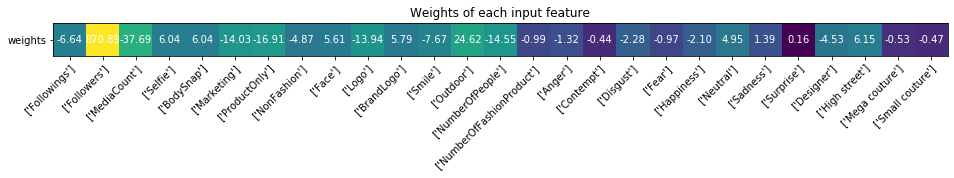

In [220]:
fig, ax = plt.subplots()
im = ax.imshow(coeffs_arr.transpose())

# We want to show all ticks...
ax.set_xticks(np.arange(len(coeffs_arr)))
ax.set_yticks(np.arange(1))
# ... and label them with the respective list entries
ax.set_xticklabels(input_columns)
ax.set_yticklabels(["weights"])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(coeffs)):
        text = ax.text(i, 0, str.format('{0:.2f}', coeffs[i]),
                       ha="center", va="center", color="w")

ax.set_title("Weights of each input feature")
fig.tight_layout()
fig.set_size_inches(15, 10.5)
fig.savefig('weights.png', dpi=100)
plt.show()

# Try a Deep Learning Model

In [41]:
X = np.array(data_new[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor', 'NumberOfPeople',
       'NumberOfFashionProduct', 'Anger', 'Contempt', 'Disgust', 'Fear',
       'Happiness', 'Neutral', 'Sadness', 'Surprise', 'Designer',
       'High street', 'Mega couture', 'Small couture']])
y = np.array(data_new['Likes'])

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [43]:
def standardize(train, test):


    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)+0.000001

    X_train = (train - mean) / std
    X_test = (test - mean) /std
    return X_train, X_test

In [44]:
X_train, X_test = standardize(X_train, X_test)

In [45]:
epsilon = 1e-200
y_train = np.log(y_train + epsilon)
y_test = np.log(y_test + epsilon)

In [49]:
def our_model():
    model = Sequential()

    model.add(Dense(units=64, activation='relu', input_dim = 24, name="input_layer"))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
    return model

In [50]:
estimator = KerasRegressor(build_fn=our_model, epochs=100, batch_size=5, verbose=1)

In [51]:
estimator.fit(X_train, y_train)

Epoch 1/100
22276/22276 [==============================] - 4s 165us/step - loss: 3599.0414 - accuracy: 9.4272e-04
Epoch 2/100
22276/22276 [==============================] - 3s 156us/step - loss: 3551.5560 - accuracy: 0.0012
Epoch 3/100
22276/22276 [==============================] - 4s 161us/step - loss: 3534.9942 - accuracy: 6.2848e-04
Epoch 4/100
22276/22276 [==============================] - 3s 153us/step - loss: 3511.2895 - accuracy: 8.9783e-04
Epoch 5/100
22276/22276 [==============================] - 3s 151us/step - loss: 3508.6606 - accuracy: 8.9783e-04
Epoch 6/100
22276/22276 [==============================] - 4s 167us/step - loss: 3487.8978 - accuracy: 0.0011
Epoch 7/100
22276/22276 [==============================] - 4s 162us/step - loss: 3485.0076 - accuracy: 8.5294e-04
Epoch 8/100
22276/22276 [==============================] - 4s 163us/step - loss: 3475.2550 - accuracy: 8.5294e-04
Epoch 9/100
22276/22276 [==============================] - 4s 158us/step - loss: 3472.3295 - acc

In [52]:
estimator.model.get_layer(name="input_layer").get_weights()[0]

array([[ 1.6602654 ,  1.0713642 , -1.8258811 , ...,  0.5432624 ,
        -0.38878947,  0.14573257],
       [-1.2050334 ,  1.6862417 ,  0.33284396, ...,  1.1423517 ,
         0.8503794 , -0.24131954],
       [ 0.5653927 ,  0.6209416 ,  0.79688084, ...,  1.3164678 ,
         0.40308785, -0.1415388 ],
       ...,
       [-0.09399433,  0.09950712,  0.09413178, ...,  0.10298966,
         0.09336752,  0.12424602],
       [ 0.23851576,  0.61894625,  0.8926927 , ...,  0.92338806,
         0.2764637 ,  0.09846526],
       [ 1.6472518 ,  0.73486257, -0.55144083, ...,  0.6065042 ,
         0.8231607 , -0.3003489 ]], dtype=float32)

In [53]:
preds = estimator.predict(X_test)

2476/2476 [==============================] - 0s 38us/step


In [54]:
r2_score(y_test, preds)

-0.02584332015658619

# Try Deep Learning Model with Bias Fixing

In [55]:
X = data_new[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor', 'NumberOfPeople',
       'NumberOfFashionProduct', 'Anger', 'Contempt', 'Disgust', 'Fear',
       'Happiness', 'Neutral', 'Sadness', 'Surprise', 'Designer',
       'High street', 'Mega couture', 'Small couture']]
y = data_new[['Likes']]

In [56]:
# add some random data to even out bias
import random
selfie_lst = selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel
indices = random.sample(selfie_lst, selfie*20)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])
marketing_lst = marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl
indices = random.sample(marketing_lst, marketing*5)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])
nonfash_lst = nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl
indices = random.sample(nonfash_lst, nonfash*2)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [58]:
def standardize(train, test):


    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)+0.000001

    X_train = (train - mean) / std
    X_test = (test - mean) /std
    return X_train, X_test

In [59]:
X_train, X_test = standardize(X_train, X_test)

In [60]:
epsilon = 1e-200
y_train = np.log(y_train + epsilon)
y_test = np.log(y_test + epsilon)

In [61]:
def our_model():
    model = Sequential()

    model.add(Dense(units=64, activation='relu', input_dim = 24, name="input_layer"))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
    return model

In [62]:
estimator = KerasRegressor(build_fn=our_model, epochs=100, batch_size=5, verbose=1)

In [63]:
estimator.fit(X_train, y_train)

Epoch 1/100
13095/37836 [=========>....................] - ETA: 4s - loss: 3479.0823 - accuracy: 9.9275e-04

KeyboardInterrupt: 

In [52]:
estimator.model.get_layer(name="input_layer").get_weights()[0]

array([[ 1.6602654 ,  1.0713642 , -1.8258811 , ...,  0.5432624 ,
        -0.38878947,  0.14573257],
       [-1.2050334 ,  1.6862417 ,  0.33284396, ...,  1.1423517 ,
         0.8503794 , -0.24131954],
       [ 0.5653927 ,  0.6209416 ,  0.79688084, ...,  1.3164678 ,
         0.40308785, -0.1415388 ],
       ...,
       [-0.09399433,  0.09950712,  0.09413178, ...,  0.10298966,
         0.09336752,  0.12424602],
       [ 0.23851576,  0.61894625,  0.8926927 , ...,  0.92338806,
         0.2764637 ,  0.09846526],
       [ 1.6472518 ,  0.73486257, -0.55144083, ...,  0.6065042 ,
         0.8231607 , -0.3003489 ]], dtype=float32)

In [53]:
preds = estimator.predict(X_test)

2476/2476 [==============================] - 0s 38us/step


In [54]:
r2_score(y_test, preds)

-0.02584332015658619

Maybe we need to investigate how the input space was normalized. Maybe the categorical variables that are represented by 1's and 0's at the end of the dataframe need to be normalized?

After log normalization of the likes we have worse results on this model.

Average loss value for Keras deep learning model based on just numeric values and predicting likes is 154K.

Maybe try using likes / followers?

# Likes to Follower Ratio

First check if there are any null likes or follower entries

In [74]:
data_new['Likes'].isnull().any() 

False

In [75]:
data_new['Followers'].isnull().any()

False

In [76]:
data_ver2 = data_new
data_ver2['LikesToFollowers'] = data_ver2['Likes'] / data_ver2['Followers']
data_ver2.head()

,Followings,Followers,MediaCount,BrandName,BrandCategory,Hashtags,Caption,ImgURL,Likes,Comments,CreationTime,Link,Selfie,BodySnap,Marketing,ProductOnly,NonFashion,Face,Logo,BrandLogo,Smile,Outdoor,NumberOfPeople,NumberOfFashionProduct,Anger,Contempt,Disgust,Fear,Happiness,Neutral,Sadness,Surprise,Designer,High street,Mega couture,Small couture,LikesToFollowers
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1171579752855683619_212070047,518.0,9840.0,541,abercrombie,High street,"beautiful, summer, fashion, love, cute, food, ...","We were born to be REAL, not to be perfect. ...",https://scontent.cdninstagram.com/t51.2885-15/...,97,0,1453883211,https://www.instagram.com/p/BBCSZPzAMIj/,0.000885,0.336438,0.741220,0.009454,0.001827,0.839466,0.890231,0.292843,0.062638,0.012164,0.931486,3.42211,0.083862,0.015089,0.000583,0.000026,0.000017,0.890586,0.009657,0.000181,0,1,0,0,0.009858
1171594777274371222_176762322,7333.0,2300.0,272,abercrombie,High street,"teen, model, brunette, selfie, hollister, snap...","Gotta run, but first, let me take selfie. Me...",https://scontent.cdninstagram.com/t51.2885-15/...,94,0,1453885002,https://www.instagram.com/p/BBCVz4YJEyW/,0.003912,0.995503,0.001728,0.002125,0.002438,0.480598,0.550629,0.063139,0.126848,0.004330,0.466329,2.91971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0.040870
1171407552643586413_581125501,131.0,605.0,106,abercrombie,High street,"alexandani, cute, llbean, beanboots, anthropol...",dress to impress\U0001f457,https://scontent.cdninstagram.com/t51.2885-15/...,91,3,1453862683,https://www.instagram.com/p/BBBrPZ2h9lt/,0.015774,0.963880,0.025719,0.027023,0.003409,0.283399,0.095724,0.037635,0.107896,0.712017,1.116500,4.69096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0.150413
1171407552643586413_581125501,131.0,605.0,106,abercrombie,High street,"alexandani, cute, llbean, beanboots, anthropol...",dress to impress\U0001f457,https://scontent.cdninstagram.com/t51.2885-15/...,94,3,1453862683,https://www.instagram.com/p/BBBrPZ2h9lt/,0.015774,0.963880,0.025719,0.027023,0.003409,0.283399,0.095724,0.037635,0.107896,0.712017,1.116500,4.69096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0.155372
1171508187966229230_2797323089,132.0,456.0,56,abercrombie,High street,"abercrombieandfitch, shopping, love, hollister...",#love #shopping #shoppen #hollister #abercro...,https://scontent.cdninstagram.com/t51.2885-15/...,9,1,1453874680,https://www.instagram.com/p/BBCCH1zMEru/,0.002021,0.014188,0.028351,0.418125,0.601519,0.010840,0.994191,0.332847,0.007911,0.002386,0.393063,1.45586,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0.019737


In [77]:
data_ver2.replace([np.inf, -np.inf], np.nan, inplace = True);

In [78]:
data_test = data_ver2[data_ver2['LikesToFollowers'].isnull()]
data_test.head()

,Followings,Followers,MediaCount,BrandName,BrandCategory,Hashtags,Caption,ImgURL,Likes,Comments,CreationTime,Link,Selfie,BodySnap,Marketing,ProductOnly,NonFashion,Face,Logo,BrandLogo,Smile,Outdoor,NumberOfPeople,NumberOfFashionProduct,Anger,Contempt,Disgust,Fear,Happiness,Neutral,Sadness,Surprise,Designer,High street,Mega couture,Small couture,LikesToFollowers
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1171240019544303946_23457617,0.0,0.0,1,acnestudios,Designer,"shop, anndemeulemeester, style, acnestudios, t...",Black? Or dark black... @00000 #totokaelo #l...,https://scontent.cdninstagram.com/t51.2885-15/...,37,0,1453842712,https://www.instagram.com/p/BBBFJefqOlK/,0.000158,0.001617,0.007038,0.997941,0.001827,0.000604,0.099600,0.073979,0.000380,0.001582,0.192986,3.91808,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1,0,0,0,NaN
1171142669094830425_252313279,36.0,0.0,0,acnestudios,Designer,"acnestudios, collegeface",#collegeface in college\U0001f610 #acnestudios,https://scontent.cdninstagram.com/t51.2885-15/...,18,1,1453831107,https://www.instagram.com/p/BBAvA10s0FZ/,0.870760,0.200230,0.063385,0.003886,0.016565,0.991469,0.052578,0.024295,0.510374,0.032716,1.752410,2.34389,3.308620e-04,0.003890,4.890000e-05,4.975480e-04,0.000018,0.829768,0.150697,0.014749,1,0,0,0,NaN
1171278619918133139_23638768,0.0,0.0,0,acnestudios,Designer,NaN,1.26 | \u2603 Cc: \U0001f4f7 @00000,https://scontent.cdninstagram.com/t51.2885-15/...,136,9,1453847313,https://www.instagram.com/p/BBBN7L5OueT/,0.008489,0.907810,0.258318,0.002872,0.000588,0.974532,0.053198,0.020144,0.215500,0.081668,1.268000,5.73313,3.104320e-04,0.000025,1.300000e-05,3.810000e-06,0.011196,0.955701,0.032682,0.000069,1,0,0,0,NaN
1170503373243750859_2795691477,0.0,0.0,1,acnestudios,Designer,"sorpreseinmacchina, acnestudios, withstyle, ga...",#jackolsen #jauria #withstyle #migraineprobl...,https://scontent.cdninstagram.com/t51.2885-15/...,10,0,1453754897,https://www.instagram.com/p/BA-dp3KlxnL/,0.375648,0.528273,0.055469,0.001185,0.009081,0.996861,0.134891,0.024669,0.513444,0.315825,1.413850,4.22136,2.080000e-07,0.000181,8.390000e-07,4.160000e-09,0.979905,0.019908,0.000003,0.000001,1,0,0,0,NaN
1170007750938083500_2120361935,39.0,0.0,0,alexanderwang,Designer,"jimmychoo, slimthickwithyourcuteass, alexander...","u\""\""I swear she's so perfect she makes me s...",https://scontent.cdninstagram.com/t51.2885-15/...,74,0,1453695814,https://www.instagram.com/p/BA8s9m7HkCs/,0.002184,0.999626,0.000747,0.000168,0.000336,0.771275,0.026620,0.001609,0.331313,0.013736,0.667217,4.49539,8.573980e-04,0.001655,4.457260e-04,2.339453e-03,0.008483,0.939227,0.021567,0.025426,1,0,0,0,NaN


Drop rows where LikesToFollowers is NAN. Likes and Followers count at both 0.

In [79]:
data_ver2 = data_ver2.dropna()

In [80]:
data_ver2['LikesToFollowers'].isnull().any()

False

In [81]:
X = data_ver2[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor', 'NumberOfPeople',
       'NumberOfFashionProduct', 'Anger', 'Contempt', 'Disgust', 'Fear',
       'Happiness', 'Neutral', 'Sadness', 'Surprise', 'Designer',
       'High street', 'Mega couture', 'Small couture']]
y = data_ver2['LikesToFollowers']

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [84]:
def standardize(train, test):


    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)+0.000001

    X_train = (train - mean) / std
    X_test = (test - mean) /std
    return X_train, X_test

In [85]:
X_train, X_test = standardize(X_train, X_test)

In [86]:
epsilon = 1e-200
y_train = np.log(y_train+epsilon)
y_test = np.log(y_test+epsilon)

In [87]:
import keras
keras.backend.floatx()
keras.backend.set_floatx('float64')
keras.backend.floatx()

'float64'

In [90]:
def our_model_ver2():
    model = Sequential()
    model.add(Dense(units=128, input_dim = 24))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))

    model.add(Dense(units=256))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))
    
    model.add(Dense(units=64, activation = 'tanh'))
    
    model.add(Dense(units=1))
    #opt = Adadelta(clipnorm=0.3)
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
    return model

estimator = KerasRegressor(build_fn=our_model_ver2, epochs=100, batch_size=500, verbose=1)

# kfold = KFold(n_splits=5)
# results = cross_val_score(estimator, X_train, y_train, cv=kfold)
# print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [91]:
estimator.fit(X_train, y_train)

Epoch 1/100
22088/22088 [==============================] - 1s 24us/step - loss: 3501.4731 - accuracy: 0.0000e+00
Epoch 2/100
22088/22088 [==============================] - 0s 12us/step - loss: 3445.6927 - accuracy: 0.0000e+00
Epoch 3/100
22088/22088 [==============================] - 0s 12us/step - loss: 3428.3030 - accuracy: 0.0000e+00
Epoch 4/100
22088/22088 [==============================] - 0s 12us/step - loss: 3414.6311 - accuracy: 0.0000e+00
Epoch 5/100
22088/22088 [==============================] - 0s 12us/step - loss: 3403.9352 - accuracy: 0.0000e+00
Epoch 6/100
22088/22088 [==============================] - 0s 12us/step - loss: 3395.5030 - accuracy: 0.0000e+00
Epoch 7/100
22088/22088 [==============================] - 0s 13us/step - loss: 3390.7823 - accuracy: 0.0000e+00
Epoch 8/100
22088/22088 [==============================] - 0s 12us/step - loss: 3380.9888 - accuracy: 0.0000e+00
Epoch 9/100
22088/22088 [==============================] - 0s 12us/step - loss: 3376.6946 - accu

In [92]:
preds = estimator.predict(X_test)

2455/2455 [==============================] - 0s 16us/step


In [93]:
r2_score(y_test, preds)

0.08511482887143362

When using log normalization of likes/followers we got 0.036 and when we did log normalization of just likes we got 0.035. Additionally, reducing the amount of test data and the batch size improves the results further to 0.0856.

# Try modifying bias and running the deep learning likes to followers model

In [126]:
data_short = data_ver2[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor']]

In [127]:
selfie, body, marketing, product, nonfash, total = 0,0,0,0,0,0
selfiel, bodyl, marketingl, productl, nonfashl = [],[],[],[],[]
thresh = 0.75
for index, row in data_short.iterrows():
    if row['Selfie'] > thresh:
        selfie+=1
        selfiel.append(index)
    if row['BodySnap'] > thresh:
        body+=1
        bodyl.append(index)
    if row['Marketing'] > thresh:
        marketing+=1
        marketingl.append(index)
    if row['ProductOnly'] > thresh:
        product+=1
        productl.append(index)
    if row['NonFashion'] > thresh:
        nonfash+=1
        nonfashl.append(index)
    total+=1

print('Selfie: ', selfie/total * 100)
print('BodySnap: ', body/total * 100)
print('Marketing: ', marketing/total * 100)
print('ProductOnly: ', product/total * 100)
print('NonFashion: ', nonfash/total * 100)

Selfie:  1.3486533838569041
BodySnap:  22.450393187466894
Marketing:  5.272379089760828
ProductOnly:  34.82459357046816
NonFashion:  7.554088742207554


In [128]:
X = data_ver2[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor', 'NumberOfPeople',
       'NumberOfFashionProduct', 'Anger', 'Contempt', 'Disgust', 'Fear',
       'Happiness', 'Neutral', 'Sadness', 'Surprise', 'Designer',
       'High street', 'Mega couture', 'Small couture']]
y = data_ver2[['LikesToFollowers']]

In [129]:
# add some random selfie data
import random
selfie_lst = selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel
indices = random.sample(selfie_lst, selfie*20)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])
marketing_lst = marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl
indices = random.sample(marketing_lst, marketing*5)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])
nonfash_lst = nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl
indices = random.sample(nonfash_lst, nonfash*2)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [131]:
def standardize(train, test):


    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)+0.000001

    X_train = (train - mean) / std
    X_test = (test - mean) /std
    return X_train, X_test

In [132]:
X_train, X_test = standardize(X_train, X_test)

In [133]:
epsilon = 1e-200
y_train = np.log(y_train+epsilon)
y_test = np.log(y_test+epsilon)

In [134]:
def our_model_ver2():
    model = Sequential()
    model.add(Dense(units=128, input_dim = 24))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))

    model.add(Dense(units=256))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))
    
    model.add(Dense(units=64, activation = 'tanh'))
    
    model.add(Dense(units=1))
    #opt = Adadelta(clipnorm=0.3)
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
    return model

estimator = KerasRegressor(build_fn=our_model_ver2, epochs=100, batch_size=500, verbose=1)
print(X_train.shape)
print(y_train.shape)

(37521, 24)
(37521, 1)


In [135]:
estimator.fit(X_train, y_train)

Epoch 1/100
37521/37521 [==============================] - 1s 20us/step - loss: 3480.5825 - accuracy: 0.0000e+00
Epoch 2/100
37521/37521 [==============================] - 1s 16us/step - loss: 3427.1404 - accuracy: 0.0000e+00
Epoch 3/100
37521/37521 [==============================] - 1s 16us/step - loss: 3398.7926 - accuracy: 0.0000e+00
Epoch 4/100
37521/37521 [==============================] - 1s 16us/step - loss: 3379.0443 - accuracy: 0.0000e+00
Epoch 5/100
37521/37521 [==============================] - 1s 15us/step - loss: 3362.0922 - accuracy: 0.0000e+00
Epoch 6/100
37521/37521 [==============================] - 1s 16us/step - loss: 3347.6671 - accuracy: 0.0000e+00
Epoch 7/100
37521/37521 [==============================] - 1s 14us/step - loss: 3335.0418 - accuracy: 0.0000e+00
Epoch 8/100
37521/37521 [==============================] - 0s 13us/step - loss: 3323.1933 - accuracy: 0.0000e+00
Epoch 9/100
37521/37521 [==============================] - 0s 13us/step - loss: 3308.2754 - accu

In [136]:
preds = estimator.predict(X_test)
print(preds)

4169/4169 [==============================] - 0s 11us/step
[ -4.32443964  -8.17024275 -37.09305906 ...  -4.32340108 -26.89924743
  -4.32443964]


In [137]:
r2_score(y_test, preds)

0.25385318068731166

# Try Engagement (Likes + Comments)

In [138]:
data_new['Comments ']

UserId
1171579752855683619_212070047     0
1171594777274371222_176762322     0
1171407552643586413_581125501     3
1171407552643586413_581125501     3
1171508187966229230_2797323089    1
                                 ..
1171575731978099465_389885373     0
1171566570370586806_253427645     1
1171566525099211846_1433754542    0
1171566525099211846_1433754542    0
1171565778125281443_253427645     1
Name: Comments , Length: 24752, dtype: int64

In [139]:
data_ver3 = data_new
data_ver3['Engagement'] = data_ver3['Likes'] + data_ver3['Comments ']
data_ver3['EngagementToFollowers'] = data_ver3['Engagement'] / data_ver3['Followers']
# data_ver3.dropna()
data_ver3.head()

,Followings,Followers,MediaCount,BrandName,BrandCategory,Hashtags,Caption,ImgURL,Likes,Comments,CreationTime,Link,Selfie,BodySnap,Marketing,ProductOnly,NonFashion,Face,Logo,BrandLogo,Smile,Outdoor,NumberOfPeople,NumberOfFashionProduct,Anger,Contempt,Disgust,Fear,Happiness,Neutral,Sadness,Surprise,Designer,High street,Mega couture,Small couture,LikesToFollowers,Engagement,EngagementToFollowers
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1171579752855683619_212070047,518.0,9840.0,541,abercrombie,High street,"beautiful, summer, fashion, love, cute, food, ...","We were born to be REAL, not to be perfect. ...",https://scontent.cdninstagram.com/t51.2885-15/...,97,0,1453883211,https://www.instagram.com/p/BBCSZPzAMIj/,0.000885,0.336438,0.741220,0.009454,0.001827,0.839466,0.890231,0.292843,0.062638,0.012164,0.931486,3.42211,0.083862,0.015089,0.000583,0.000026,0.000017,0.890586,0.009657,0.000181,0,1,0,0,0.009858,97,0.009858
1171594777274371222_176762322,7333.0,2300.0,272,abercrombie,High street,"teen, model, brunette, selfie, hollister, snap...","Gotta run, but first, let me take selfie. Me...",https://scontent.cdninstagram.com/t51.2885-15/...,94,0,1453885002,https://www.instagram.com/p/BBCVz4YJEyW/,0.003912,0.995503,0.001728,0.002125,0.002438,0.480598,0.550629,0.063139,0.126848,0.004330,0.466329,2.91971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0.040870,94,0.040870
1171407552643586413_581125501,131.0,605.0,106,abercrombie,High street,"alexandani, cute, llbean, beanboots, anthropol...",dress to impress\U0001f457,https://scontent.cdninstagram.com/t51.2885-15/...,91,3,1453862683,https://www.instagram.com/p/BBBrPZ2h9lt/,0.015774,0.963880,0.025719,0.027023,0.003409,0.283399,0.095724,0.037635,0.107896,0.712017,1.116500,4.69096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0.150413,94,0.155372
1171407552643586413_581125501,131.0,605.0,106,abercrombie,High street,"alexandani, cute, llbean, beanboots, anthropol...",dress to impress\U0001f457,https://scontent.cdninstagram.com/t51.2885-15/...,94,3,1453862683,https://www.instagram.com/p/BBBrPZ2h9lt/,0.015774,0.963880,0.025719,0.027023,0.003409,0.283399,0.095724,0.037635,0.107896,0.712017,1.116500,4.69096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0.155372,97,0.160331
1171508187966229230_2797323089,132.0,456.0,56,abercrombie,High street,"abercrombieandfitch, shopping, love, hollister...",#love #shopping #shoppen #hollister #abercro...,https://scontent.cdninstagram.com/t51.2885-15/...,9,1,1453874680,https://www.instagram.com/p/BBCCH1zMEru/,0.002021,0.014188,0.028351,0.418125,0.601519,0.010840,0.994191,0.332847,0.007911,0.002386,0.393063,1.45586,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0.019737,10,0.021930


In [140]:
data_ver3.replace([np.inf, -np.inf], np.nan, inplace = True);

In [141]:
data_test = data_ver3[data_ver3['EngagementToFollowers'].isnull()]
data_test.head()

,Followings,Followers,MediaCount,BrandName,BrandCategory,Hashtags,Caption,ImgURL,Likes,Comments,CreationTime,Link,Selfie,BodySnap,Marketing,ProductOnly,NonFashion,Face,Logo,BrandLogo,Smile,Outdoor,NumberOfPeople,NumberOfFashionProduct,Anger,Contempt,Disgust,Fear,Happiness,Neutral,Sadness,Surprise,Designer,High street,Mega couture,Small couture,LikesToFollowers,Engagement,EngagementToFollowers
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1171240019544303946_23457617,0.0,0.0,1,acnestudios,Designer,"shop, anndemeulemeester, style, acnestudios, t...",Black? Or dark black... @00000 #totokaelo #l...,https://scontent.cdninstagram.com/t51.2885-15/...,37,0,1453842712,https://www.instagram.com/p/BBBFJefqOlK/,0.000158,0.001617,0.007038,0.997941,0.001827,0.000604,0.099600,0.073979,0.000380,0.001582,0.192986,3.91808,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1,0,0,0,NaN,37,NaN
1171142669094830425_252313279,36.0,0.0,0,acnestudios,Designer,"acnestudios, collegeface",#collegeface in college\U0001f610 #acnestudios,https://scontent.cdninstagram.com/t51.2885-15/...,18,1,1453831107,https://www.instagram.com/p/BBAvA10s0FZ/,0.870760,0.200230,0.063385,0.003886,0.016565,0.991469,0.052578,0.024295,0.510374,0.032716,1.752410,2.34389,3.308620e-04,0.003890,4.890000e-05,4.975480e-04,0.000018,0.829768,0.150697,0.014749,1,0,0,0,NaN,19,NaN
1171278619918133139_23638768,0.0,0.0,0,acnestudios,Designer,NaN,1.26 | \u2603 Cc: \U0001f4f7 @00000,https://scontent.cdninstagram.com/t51.2885-15/...,136,9,1453847313,https://www.instagram.com/p/BBBN7L5OueT/,0.008489,0.907810,0.258318,0.002872,0.000588,0.974532,0.053198,0.020144,0.215500,0.081668,1.268000,5.73313,3.104320e-04,0.000025,1.300000e-05,3.810000e-06,0.011196,0.955701,0.032682,0.000069,1,0,0,0,NaN,145,NaN
1170503373243750859_2795691477,0.0,0.0,1,acnestudios,Designer,"sorpreseinmacchina, acnestudios, withstyle, ga...",#jackolsen #jauria #withstyle #migraineprobl...,https://scontent.cdninstagram.com/t51.2885-15/...,10,0,1453754897,https://www.instagram.com/p/BA-dp3KlxnL/,0.375648,0.528273,0.055469,0.001185,0.009081,0.996861,0.134891,0.024669,0.513444,0.315825,1.413850,4.22136,2.080000e-07,0.000181,8.390000e-07,4.160000e-09,0.979905,0.019908,0.000003,0.000001,1,0,0,0,NaN,10,NaN
1170007750938083500_2120361935,39.0,0.0,0,alexanderwang,Designer,"jimmychoo, slimthickwithyourcuteass, alexander...","u\""\""I swear she's so perfect she makes me s...",https://scontent.cdninstagram.com/t51.2885-15/...,74,0,1453695814,https://www.instagram.com/p/BA8s9m7HkCs/,0.002184,0.999626,0.000747,0.000168,0.000336,0.771275,0.026620,0.001609,0.331313,0.013736,0.667217,4.49539,8.573980e-04,0.001655,4.457260e-04,2.339453e-03,0.008483,0.939227,0.021567,0.025426,1,0,0,0,NaN,74,NaN


In [142]:
data_ver3 = data_ver3.dropna()

In [143]:
data_ver3['EngagementToFollowers'].isnull().any()

False

### Include the bias modification

In [144]:
data_short = data_ver3[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor']]

In [145]:
selfie, body, marketing, product, nonfash, total = 0,0,0,0,0,0
selfiel, bodyl, marketingl, productl, nonfashl = [],[],[],[],[]
thresh = 0.75
for index, row in data_short.iterrows():
    if row['Selfie'] > thresh:
        selfie+=1
        selfiel.append(index)
    if row['BodySnap'] > thresh:
        body+=1
        bodyl.append(index)
    if row['Marketing'] > thresh:
        marketing+=1
        marketingl.append(index)
    if row['ProductOnly'] > thresh:
        product+=1
        productl.append(index)
    if row['NonFashion'] > thresh:
        nonfash+=1
        nonfashl.append(index)
    total+=1

print('Selfie: ', selfie/total * 100)
print('BodySnap: ', body/total * 100)
print('Marketing: ', marketing/total * 100)
print('ProductOnly: ', product/total * 100)
print('NonFashion: ', nonfash/total * 100)

Selfie:  1.3486533838569041
BodySnap:  22.450393187466894
Marketing:  5.272379089760828
ProductOnly:  34.82459357046816
NonFashion:  7.554088742207554


In [146]:
X = data_ver3[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor', 'NumberOfPeople',
       'NumberOfFashionProduct', 'Anger', 'Contempt', 'Disgust', 'Fear',
       'Happiness', 'Neutral', 'Sadness', 'Surprise', 'Designer',
       'High street', 'Mega couture', 'Small couture']]
y = data_ver3[['EngagementToFollowers']]

In [147]:
# add some random selfie data
import random
selfie_lst = selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel
indices = random.sample(selfie_lst, selfie*20)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])
marketing_lst = marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl
indices = random.sample(marketing_lst, marketing*5)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])
nonfash_lst = nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl
indices = random.sample(nonfash_lst, nonfash*2)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [149]:
X_train, X_test = standardize(X_train, X_test) # standardize

In [150]:
epsilon = 1e-200
y_train = np.log(y_train+epsilon)
y_test = np.log(y_test+epsilon)

In [151]:
def our_model_ver2():
    model = Sequential()
    model.add(Dense(units=128, input_dim = 24))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))

    model.add(Dense(units=256))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))
    
    model.add(Dense(units=64, activation = 'tanh'))
    
    model.add(Dense(units=1))
    #opt = Adadelta(clipnorm=0.3)
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
    return model

estimator = KerasRegressor(build_fn=our_model_ver2, epochs=100, batch_size=500, verbose=1)
print(X_train.shape)
print(y_train.shape) # run v2 of model

(37486, 24)
(37486, 1)


In [ ]:
estimator.fit(X_train, y_train)

Epoch 1/100
37486/37486 [==============================] - 1s 17us/step - loss: 3162.3378 - accuracy: 2.6677e-05
Epoch 2/100
37486/37486 [==============================] - 0s 12us/step - loss: 3117.1635 - accuracy: 0.0000e+00
Epoch 3/100
37486/37486 [==============================] - 0s 12us/step - loss: 3091.9766 - accuracy: 0.0000e+00
Epoch 4/100
37486/37486 [==============================] - 0s 12us/step - loss: 3078.2794 - accuracy: 0.0000e+00
Epoch 5/100
36500/37486 [============================>.] - ETA: 0s - loss: 3074.2108 - accuracy: 0.0000e+00

In [ ]:
preds = estimator.predict(X_test)
print(preds)

In [ ]:
r2_score(y_test, preds) # score for engagement to followers

only a slight improvement from LikesToFollowers deep learning model

# Likes as a Categorical Variable

In [39]:
data = pd.read_csv('fashion_data_on_Instagram.csv')
data.set_index('UserId', inplace = True)
data.head()

data_new = pd.concat([data, brand_category], sort = False, axis = 1)
data_new.head()

data_ver2 = data_new

data_ver2 = data_ver2.dropna()
print(data_ver2.isnull().any())

data_likecat = data_ver2[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor']]
print(data_likecat.shape)

selfie, body, marketing, product, nonfash, total = 0,0,0,0,0,0
selfiel, bodyl, marketingl, productl, nonfashl = [],[],[],[],[]
thresh = 0.75
for index, row in data_ver2.iterrows():
    if row['Selfie'] > thresh:
        selfie+=1
        selfiel.append(index)
    if row['BodySnap'] > thresh:
        body+=1
        bodyl.append(index)
    if row['Marketing'] > thresh:
        marketing+=1
        marketingl.append(index)
    if row['ProductOnly'] > thresh:
        product+=1
        productl.append(index)
    if row['NonFashion'] > thresh:
        nonfash+=1
        nonfashl.append(index)
    total+=1

print('Selfie: ', selfie/total * 100)
print('BodySnap: ', body/total * 100)
print('Marketing: ', marketing/total * 100)
print('ProductOnly: ', product/total * 100)
print('NonFashion: ', nonfash/total * 100)

Followings                False
Followers                 False
MediaCount                False
BrandName                 False
BrandCategory             False
Hashtags                  False
Caption                   False
ImgURL                    False
Likes                     False
Comments                  False
CreationTime              False
Link                      False
Selfie                    False
BodySnap                  False
Marketing                 False
ProductOnly               False
NonFashion                False
Face                      False
Logo                      False
BrandLogo                 False
Smile                     False
Outdoor                   False
NumberOfPeople            False
NumberOfFashionProduct    False
Anger                     False
Contempt                  False
Disgust                   False
Fear                      False
Happiness                 False
Neutral                   False
Sadness                   False
Surprise

In [40]:
print("0: {q0}, 25: {q25}, 50: {q50}, 75: {q75}, 100:{q100}".format(q0 = \
    np.percentile(data_ver2['Likes'], 0), q25 = np.percentile(data_ver2['Likes'], 25), q50 = \
    np.percentile(data_ver2['Likes'], 50), q75 = np.percentile(data_ver2['Likes'], 75), q100 = \
        np.percentile(data_ver2['Likes'], 100)))

print("75: {q75}, 80: {q80}, 85: {q85}, 90: {q90}, 95: {q95}, 100:{q100}".format(q80 = \
    np.percentile(data_ver2['Likes'], 80), q85 = np.percentile(data_ver2['Likes'], 85), q90 = \
    np.percentile(data_ver2['Likes'], 90), q75 = np.percentile(data_ver2['Likes'], 75), q100 = \
        np.percentile(data_ver2['Likes'], 100), q95 = np.percentile(data_ver2['Likes'], 95)))

## categories are 0, 1, 2, 3 corresponding to the 0-25, 25-50, 50-75, and 75-100 percn
conversion_array = tuple((np.percentile(data_ver2['Likes'], 0), np.percentile(data_ver2['Likes'], 25), \
    np.percentile(data_ver2['Likes'], 50), np.percentile(data_ver2['Likes'], 75), \
    np.percentile(data_ver2['Likes'], 100)))
print(conversion_array)

0: 0.0, 25: 9.0, 50: 22.0, 75: 53.0, 100:101922.0
75: 53.0, 80: 67.0, 85: 90.0, 90: 137.0, 95: 272.0, 100:101922.0
(0.0, 9.0, 22.0, 53.0, 101922.0)


In [41]:

def convert_to_category(value, conversion_array):
#     conversion_array = [np.percentile(data_ver2['Likes'], 0), np.percentile(data_ver2['Likes'], 25), \
#     np.percentile(data_ver2['Likes'], 50), np.percentile(data_ver2['Likes'], 75), \
#     np.percentile(data_ver2['Likes'], 100)]
    
    for i in range(len(conversion_array) - 1):
        if in_between(value, conversion_array[i], conversion_array[i+1]):
            return i
        
    return len(conversion_array) - 2
def in_between(target, a, b):
    # inclusive bottom, exclusive top
    if target < a:
        return False
    if target >= b:
        return False
    
    return True



In [42]:
X_likecat = data_ver2[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor', 'NumberOfPeople',
       'NumberOfFashionProduct', 'Anger', 'Contempt', 'Disgust', 'Fear',
       'Happiness', 'Neutral', 'Sadness', 'Surprise', 'Designer',
       'High street', 'Mega couture', 'Small couture']]
data_ver2['Likes_categorical'] = data_ver2['Likes'].apply(lambda x: convert_to_category(x, conversion_array))

y_likecat = data_ver2[['Likes_categorical']]
print(X_likecat.shape)

print(X_likecat.isnull().any(), y_likecat.isnull().any())

data_ver2[['Likes_categorical']].head()
# data_ver2.loc['1171579752855683619_212070047', :]

(24589, 24)
Selfie                    False
BodySnap                  False
Marketing                 False
ProductOnly               False
NonFashion                False
Face                      False
Logo                      False
BrandLogo                 False
Smile                     False
Outdoor                   False
NumberOfPeople            False
NumberOfFashionProduct    False
Anger                     False
Contempt                  False
Disgust                   False
Fear                      False
Happiness                 False
Neutral                   False
Sadness                   False
Surprise                  False
Designer                  False
High street               False
Mega couture              False
Small couture             False
dtype: bool Likes_categorical    False
dtype: bool


/Users/wentingxie/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Likes_categorical
UserId,
1171579752855683619_212070047,3
1171594777274371222_176762322,3
1171407552643586413_581125501,3
1171407552643586413_581125501,3
1171508187966229230_2797323089,1


In [43]:
# add some random selfie data
import random
random.seed(0)
selfie_lst = selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel
indices = random.sample(selfie_lst, selfie*20)
print("selfie bias: ", selfie*20)
print(X_likecat.isnull().any(), y_likecat.isnull().any())
X_likecat = X_likecat.append(X_likecat.loc[indices])
y_likecat = y_likecat.append(y_likecat.loc[indices])
marketing_lst = marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl
indices = random.sample(marketing_lst, marketing*5)
print("marketing bias: ", marketing*5)

print(X_likecat.isnull().any(), y_likecat.isnull().any())
X_likecat = X_likecat.append(X_likecat.loc[indices])
y_likecat = y_likecat.append(y_likecat.loc[indices])
nonfash_lst = nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl
indices = random.sample(nonfash_lst, nonfash*2)
print("nonfash bias: ", nonfash*2)

print(X_likecat.isnull().any(), y_likecat.isnull().any())
X_likecat = X_likecat.append(X_likecat.loc[indices])
y_likecat = y_likecat.append(y_likecat.loc[indices])


print(X_likecat.isnull().any(), y_likecat.isnull().any())

selfie bias:  6660
Selfie                    False
BodySnap                  False
Marketing                 False
ProductOnly               False
NonFashion                False
Face                      False
Logo                      False
BrandLogo                 False
Smile                     False
Outdoor                   False
NumberOfPeople            False
NumberOfFashionProduct    False
Anger                     False
Contempt                  False
Disgust                   False
Fear                      False
Happiness                 False
Neutral                   False
Sadness                   False
Surprise                  False
Designer                  False
High street               False
Mega couture              False
Small couture             False
dtype: bool Likes_categorical    False
dtype: bool
marketing bias:  6480
Selfie                    False
BodySnap                  False
Marketing                 False
ProductOnly               False
NonFashion  

In [44]:
def standardize(train, test):
    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)+0.000001

    X_train = (train - mean) / std
    X_test = (test - mean) /std
    return X_train, X_test

X_train_likecat, X_test_likecat, y_train_likecat, y_test_likecat = train_test_split(X_likecat\
            , y_likecat, test_size=0.1, random_state=42)

X_train_likecat, X_test_likecat = standardize(X_train_likecat, X_test_likecat)
print(X_train_likecat.shape)

(37588, 24)


In [45]:
import keras
def our_model_likecat():
    model = Sequential()
    model.add(Dense(units=128, input_dim = 24))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))

    model.add(Dense(units=256))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))
    
    model.add(Dense(units=64, activation = 'tanh'))
    
    model.add(Dense(units=4, activation='softmax'))

    #opt = Adadelta(clipnorm=0.3)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

estimator_likecat = KerasRegressor(build_fn=our_model_likecat, epochs=100, batch_size=500, verbose=1)
print(X_train_likecat.shape)
print(y_train_likecat.shape)

y_train_binary = keras.utils.to_categorical(y_train_likecat['Likes_categorical'].tolist(), 4)
y_test_binary = keras.utils.to_categorical(y_test_likecat['Likes_categorical'].tolist(), 4)
print(y_train_binary[0:5], y_train_likecat.head())
estimator_likecat.fit(X_train_likecat, y_train_binary)

(37588, 24)
(37588, 1)
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]                                 Likes_categorical
UserId                                           
1164122790029176623_1404277058                  2
1170956908459321844_191030121                   3
1171528086692449639_1533458218                  2
1167537050199266606_54068844                    2
1155696005760480829_695833132                   1
Epoch 1/100
37588/37588 [==============================] - 1s 22us/step - loss: 1.3030 - accuracy: 0.3638
Epoch 2/100
37588/37588 [==============================] - 1s 15us/step - loss: 1.2633 - accuracy: 0.3965
Epoch 3/100
37588/37588 [==============================] - 1s 15us/step - loss: 1.2515 - accuracy: 0.4043
Epoch 4/100
37588/37588 [==============================] - 1s 15us/step - loss: 1.2425 - accuracy: 0.4132
Epoch 5/100
37588/37588 [==============================] - 1s 14us/step - loss: 1.2323 - accuracy: 0.4230
Epoch 6/100
37588/375

37588/37588 [==============================] - 0s 13us/step - loss: 1.0275 - accuracy: 0.5314
Epoch 74/100
37588/37588 [==============================] - 0s 13us/step - loss: 1.0287 - accuracy: 0.5327
Epoch 75/100
37588/37588 [==============================] - 0s 13us/step - loss: 1.0264 - accuracy: 0.5350
Epoch 76/100
37588/37588 [==============================] - 0s 13us/step - loss: 1.0262 - accuracy: 0.5321
Epoch 77/100
37588/37588 [==============================] - 0s 13us/step - loss: 1.0246 - accuracy: 0.5344
Epoch 78/100
37588/37588 [==============================] - 0s 13us/step - loss: 1.0229 - accuracy: 0.5335
Epoch 79/100
37588/37588 [==============================] - 0s 13us/step - loss: 1.0226 - accuracy: 0.5306
Epoch 80/100
37588/37588 [==============================] - 0s 13us/step - loss: 1.0186 - accuracy: 0.5388
Epoch 81/100
37588/37588 [==============================] - 0s 12us/step - loss: 1.0214 - accuracy: 0.5358
Epoch 82/100
37588/37588 [========================

In [26]:
y_train_likecat['Likes_categorical'].isnull().any()

False

In [46]:
preds_likecat = estimator_likecat.predict(X_test_likecat)
print(preds_likecat)
r2_score_likecat = r2_score(y_test_binary, preds_likecat)
print(r2_score_likecat)

4177/4177 [==============================] - 0s 29us/step
[[2.08208915e-02 1.25313416e-01 3.51850033e-01 5.02015650e-01]
 [1.90374106e-01 3.73819143e-01 2.46749237e-01 1.89057454e-01]
 [4.42853272e-01 2.88863182e-01 1.61157236e-01 1.07126296e-01]
 ...
 [9.19755399e-01 4.70370613e-02 3.24799381e-02 7.27554783e-04]
 [3.14416140e-01 1.74631417e-01 2.32483134e-01 2.78469384e-01]
 [2.36732006e-01 3.02379429e-01 2.72691429e-01 1.88197151e-01]]
0.31668923808090693
